In [13]:
import brambox as bb
import pandas as pd
import dataset
import utils
import numpy as np
from functools import partial
import cv2
import os

%matplotlib inline
import matplotlib.pyplot as plt

# Annotations

In [2]:
def parse_annos(list_file):
    anno = dataset.parse_annos(list_file, '../data/video', 15)
    anno = bb.util.concat(anno)
    anno['image'] = anno.image.cat.rename_categories([os.path.join(*cat.split(os.sep)[-3:]) for cat in anno.image.cat.categories])
    return anno

anno_90 = parse_annos('../data/video/meta_test/all_90.txt')
display(anno_90.head())

anno_45 = parse_annos('../data/video/meta_test/all_45.txt')
display(anno_45.head())

INFO         Parsing annotations
100%|██████████| 3/3 [00:00<00:00,  3.94it/s]


image class_label   id  x_top_left  y_top_left  width  \
0  clip000/img/image0000159      person  0.0       29.40       10.90   2.60   
1  clip000/img/image0000160      person  0.0       28.65       10.57   3.35   
2  clip000/img/image0000161      person  0.0       27.90       10.23   4.10   
3  clip000/img/image0000162      person  0.0       27.15        9.90   4.85   
4  clip000/img/image0000163      person  0.0       26.40        9.57   5.60   

   height  occluded  truncated   lost  difficult  ignore  
0    4.10       0.0        0.0  False      False    True  
1    4.73       0.0        0.0  False      False   False  
2    5.37       0.0        0.0  False      False   False  
3    6.00       0.0        0.0  False      False   False  
4    6.63       0.0        0.0  False      False   False

INFO         Parsing annotations
100%|██████████| 3/3 [00:00<00:00,  5.10it/s]


image class_label   id  x_top_left  y_top_left  width  \
0  clip003/img/image0000109      person  0.0        26.8        21.1    5.2   
1  clip003/img/image0000110      person  0.0        26.2        20.9    5.7   
2  clip003/img/image0000111      person  0.0        25.6        16.9    6.2   
3  clip003/img/image0000112      person  0.0        23.5        14.8    8.6   
4  clip003/img/image0000113      person  0.0        23.2        14.1    8.7   

   height  occluded  truncated   lost  difficult  ignore  
0     2.7       0.0        0.0  False      False    True  
1     3.0       0.0        0.0  False      False   False  
2     7.1       0.0        0.0  False      False   False  
3     8.0       0.0        0.0  False      False   False  
4     8.8       0.0        0.0  False      False   False

# Matching criteria

In [19]:
# Matching criteria
match_criteria_thresh = 0.5
match_criteria = partial(bb.stat.coordinates.ioa, denominator='a')
#match_criteria = bb.stat.coordinates.iou

# Baseline model

## Parse detections

In [20]:
# list all detection files
base_dir = '/home/maarten/data/datasets/melexis/MLDetectionExtensive/test'

def list_detection_files(clip):
    clip_dir = os.path.join(base_dir, clip)
    return [os.path.join(clip_dir, f) for f in os.listdir(clip_dir)]

def load_detections(clip_name):
    # load
    detection_files = list_detection_files(os.path.join(clip_name, 'labels_jre'))
    det_baseline = bb.io.load('anno_ml_detection', detection_files)
    
    # rename categories
    cats = det_baseline.image.cat.categories
    cats = [c.replace('label_', f'{clip_name}/img/image') for c in cats]
    det_baseline.image = det_baseline.image.cat.rename_categories(cats)
    
    # convert annotation dataframe to detection dataframe by selecting the nessesary columns and adding a confidence column
    det_baseline = det_baseline[['image', 'class_label', 'id', 'x_top_left', 'y_top_left', 'width', 'height']]
    det_baseline['confidence'] = 1.0
    
    # remove very small boxes
    det_baseline = det_baseline[(det_baseline['width'] * det_baseline['height']) >= 2]
    
    return det_baseline
    
det_90_baseline = bb.util.concat([load_detections('clip000'),
                                  load_detections('clip001'),
                                  load_detections('clip002')], ignore_index=True, sort=False)

det_45_baseline = bb.util.concat([load_detections('clip003'),
                                  load_detections('clip004'),
                                  load_detections('clip005')], ignore_index=True, sort=False)

display(det_90_baseline.head())
display(det_45_baseline.head())

image class_label  id  x_top_left  y_top_left  width  \
0  clip000/img/image0000163      person NaN        29.0        12.0    2.0   
1  clip000/img/image0000164      person NaN        28.0        11.0    3.0   
2  clip000/img/image0000165      person NaN        28.0        11.0    3.0   
3  clip000/img/image0000166      person NaN        28.0        11.0    3.0   
4  clip000/img/image0000167      person NaN        28.0        11.0    3.0   

   height  confidence  
0     2.0         1.0  
1     3.0         1.0  
2     3.0         1.0  
3     5.0         1.0  
4     4.0         1.0

image class_label  id  x_top_left  y_top_left  width  \
0  clip003/img/image0000113      person NaN        30.0        14.0    1.0   
1  clip003/img/image0000116      person NaN        24.0        12.0    5.0   
2  clip003/img/image0000117      person NaN        24.0        10.0    5.0   
3  clip003/img/image0000118      person NaN        22.0         8.0    5.0   
4  clip003/img/image0000119      person NaN        20.0         8.0    5.0   

   height  confidence  
0     2.0         1.0  
1     5.0         1.0  
2     3.0         1.0  
3     9.0         1.0  
4     8.0         1.0

## Show TP, FP and FN

In [21]:
# Compute TP,FP
tpfp_det_90 = bb.stat.match_det(det_90_baseline, anno_90, match_criteria_thresh, criteria=match_criteria)
tpfp_det_45 = bb.stat.match_det(det_45_baseline, anno_45, match_criteria_thresh, criteria=match_criteria)

WARNING    [brambox.stat._matchboxes] Annotation and detection dataframes do not have the same image categories
WARNING    [brambox.stat._matchboxes] Annotation and detection dataframes do not have the same image categories


WARNING    [brambox.stat._matchboxes] Annotation and detection dataframes do not have the same image categories


../data/video/datatest/clip000/img/image0000164.tiff


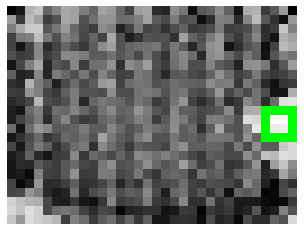

../data/video/datatest/clip000/img/image0000174.tiff


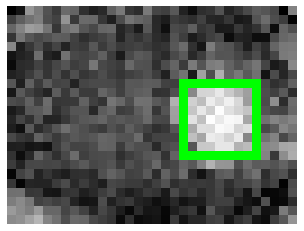

../data/video/datatest/clip000/img/image0000184.tiff


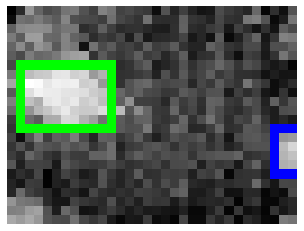

../data/video/datatest/clip000/img/image0000194.tiff


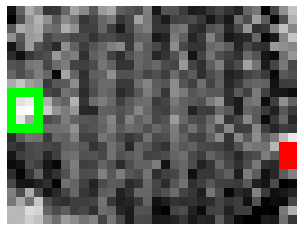

../data/video/datatest/clip000/img/image0000204.tiff


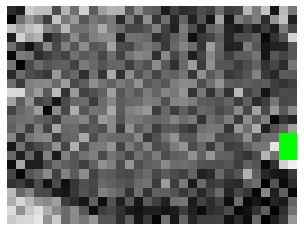

../data/video/datatest/clip000/img/image0000214.tiff


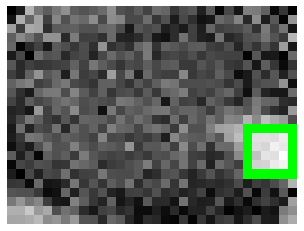

../data/video/datatest/clip000/img/image0000224.tiff


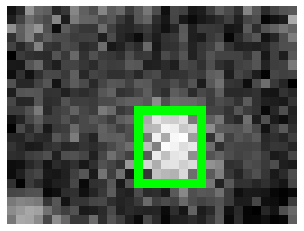

../data/video/datatest/clip000/img/image0000234.tiff


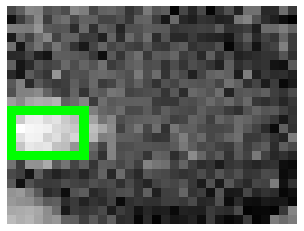

../data/video/datatest/clip000/img/image0000244.tiff


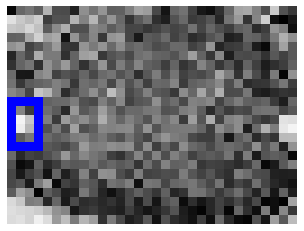

../data/video/datatest/clip000/img/image0000254.tiff


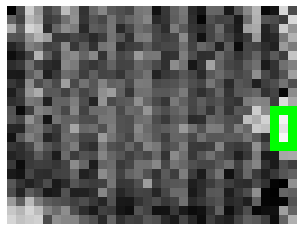

WARNING    [brambox.stat._matchboxes] Annotation and detection dataframes do not have the same image categories


../data/video/datatest/clip003/img/image0000100.tiff


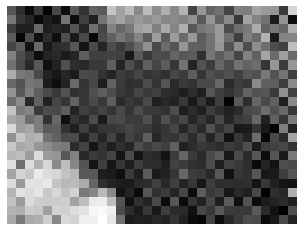

../data/video/datatest/clip003/img/image0000110.tiff


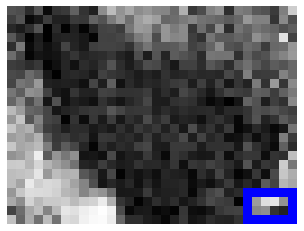

../data/video/datatest/clip003/img/image0000120.tiff


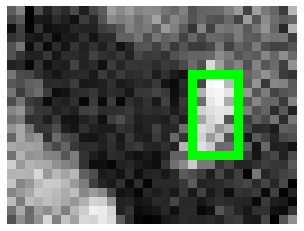

../data/video/datatest/clip003/img/image0000130.tiff


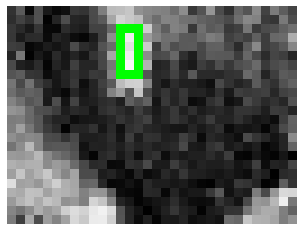

../data/video/datatest/clip003/img/image0000140.tiff


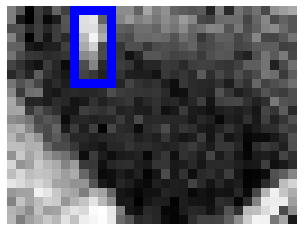

../data/video/datatest/clip003/img/image0000150.tiff


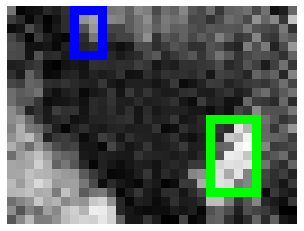

../data/video/datatest/clip003/img/image0000160.tiff


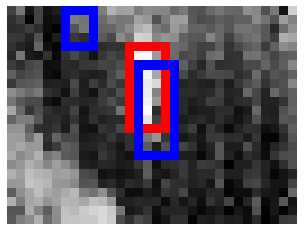

../data/video/datatest/clip003/img/image0000170.tiff


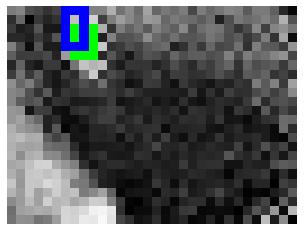

../data/video/datatest/clip003/img/image0000180.tiff


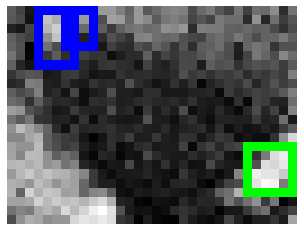

../data/video/datatest/clip003/img/image0000190.tiff


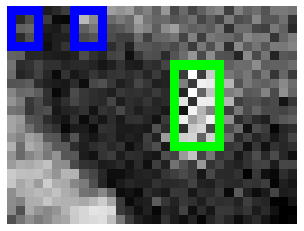

In [22]:
def show_tf_fp_fn_baseline(det, tpfp_det, anno, show_range):
    # Compute FN
    fn_anno = bb.stat.match_anno(det, anno, match_criteria_thresh, criteria=match_criteria)
    fn_anno = fn_anno[fn_anno.detection.isnull()]

    # Add correct color
    tpfp_det['color'] = [(0, 255, 0) if tp else (0, 0, 255) for tp in tpfp_det.tp]  # TP boxes green, FP boxes red
    fn_anno['color'] = [(255, 0, 0)] * fn_anno.shape[0]                             # FN boxes blue

    # Only keep necessary columns (to be able to combine dataframes)
    boxes1 = tpfp_det[['image', 'class_label', 'x_top_left', 'y_top_left', 'width', 'height', 'color']]
    boxes2 = fn_anno[['image', 'class_label', 'x_top_left', 'y_top_left', 'width', 'height', 'color']]

    # Concatenate dataframes
    boxes = bb.util.concat([boxes1, boxes2], sort=False, ignore_index=True)

    def read_image(img_id):
        img_path = os.path.join('..', 'data', 'video', 'datatest', img_id + '.tiff')
        print(img_path)
        img = cv2.imread(img_path, -1)
        img = utils.apply_agc(img)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        return img

    # Visualize
    drawer = bb.util.BoxDrawer(
        images=read_image,
        boxes=boxes,
        size=1,
        method=bb.util.DrawMethod.CV
    )

    for i in range(*show_range):
        plt.axis('off')
        plt.imshow(drawer[i])
        plt.show()
        
show_tf_fp_fn_baseline(det_90_baseline, tpfp_det_90, anno_90, (164, 264, 10))
show_tf_fp_fn_baseline(det_45_baseline, tpfp_det_45, anno_45, (100, 200, 10))

## Calculate Precision, Recall and F1-score

In [23]:
pr = bb.stat.pr(tpfp_det_90, anno_90, match_criteria_thresh)
f1 = bb.stat.fscore(pr)

print("Results 90 degree camera angle:")
print(f"Precision:\t {float(pr.precision) * 100:.2f}%")
print(f"Recall:\t\t {float(pr.recall) * 100:.2f}%")
print(f"F1:\t\t {float(f1.f1) * 100:.2f}%")

pr = bb.stat.pr(tpfp_det_45, anno_45, match_criteria_thresh)
f1 = bb.stat.fscore(pr)

print("Results 45 degree camera angle:")
print(f"Precision:\t {float(pr.precision) * 100:.2f}%")
print(f"Recall:\t\t {float(pr.recall) * 100:.2f}%")
print(f"F1:\t\t {float(f1.f1) * 100:.2f}%")

Results 90 degree camera angle:
Precision:	 89.87%
Recall:		 88.19%
F1:		 89.02%
Results 45 degree camera angle:
Precision:	 69.18%
Recall:		 60.08%
F1:		 64.31%


# Our model

## Parse detections

In [24]:
det_90_ours = pd.read_parquet('detections/set06_prune_maarten-denayer_September17_20_48_43_microyolo_l2_prune_90_pruned-49_quant.parquet')

det_90_ours['image'] = det_90_ours.image.cat.rename_categories([os.path.join(*cat.split(os.sep)[-3:]) for cat in det_90_ours.image.cat.categories])
display(det_90_ours.head())


det_45_ours = pd.read_parquet('detections/set06_prune_maarten-denayer_September19_11_21_11_microyolo_l2_prune_pruned-44_quant.parquet')

det_45_ours['image'] = det_45_ours.image.cat.rename_categories([os.path.join(*cat.split(os.sep)[-3:]) for cat in det_45_ours.image.cat.categories])
display(det_45_ours.head())

image class_label  id  x_top_left  y_top_left  \
0  clip000/img/image0000008      person NaN    5.255865  -18.290503   
1  clip000/img/image0000008      person NaN  -18.744135   -2.290503   
2  clip000/img/image0000008      person NaN  -10.197264   -4.723404   
3  clip000/img/image0000008      person NaN    5.802736    3.276596   
4  clip000/img/image0000008      person NaN    9.936657  -10.150156   

       width     height  confidence  
0  49.488270  48.581005    0.017458  
1  49.488270  48.581005    0.018969  
2  32.394527  21.446808    0.018451  
3  32.394527  21.446808    0.017948  
4  24.126686  24.300312    0.017458

image class_label  id  x_top_left  y_top_left  \
0  clip003/img/image0000008      person NaN  -11.707470  -14.088041   
1  clip003/img/image0000008      person NaN   12.292530   -6.088041   
2  clip003/img/image0000008      person NaN    2.499230    0.948857   
3  clip003/img/image0000008      person NaN   20.938672   -9.950508   
4  clip003/img/image0000008      person NaN    9.499079   -4.221314   

       width     height  confidence  
0  35.414940  48.176083    0.018754  
1  35.414940  48.176083    0.018198  
2  31.001539  26.102285    0.021151  
3  18.122656  31.901016    0.018754  
4  17.001842  20.442628    0.017658

## Find optimal working point of our model

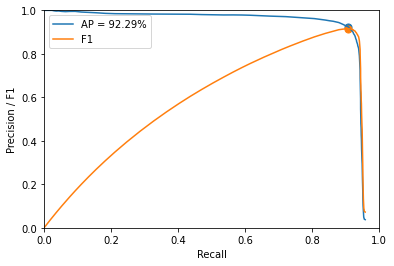

Results 90 degree camera angle:
Threshold:	 30.63%
Precision:	 92.39%
Recall:		 90.87%
F1:		 91.62%


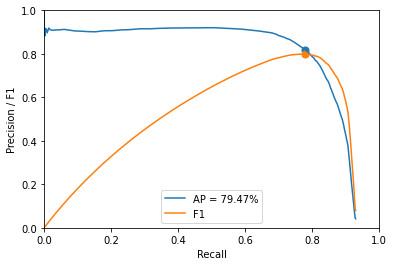

Results 45 degree camera angle:
Threshold:	 33.74%
Precision:	 81.82%
Recall:		 78.07%
F1:		 79.90%


In [25]:
def find_working_point(anno, det):
    # Compute TP,FP
    tpfp_det = bb.stat.match_det(det, anno, match_criteria_thresh, criteria=match_criteria)

    # calculate PR-curve
    pr = bb.stat.pr(tpfp_det, anno, match_criteria_thresh)
    ap = bb.stat.ap(pr)

    # Find detection threshold with maximal F1
    f1 = bb.stat.fscore(pr)
    threshold = bb.stat.peak(f1)

    # Find point on PR-curve that matches the computed detection threshold
    pr_point = bb.stat.point(pr, threshold.confidence)

    # Plot
    ax = pr.plot('recall', 'precision', label=f'AP = {round(100*ap, 2)}%')
    plt.scatter(pr_point.recall, pr_point.precision, s=50)
    f1.plot('recall', 'f1', label='F1', ax=ax)
    plt.scatter(threshold.recall, threshold.f1, s=50)

    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision / F1')
    plt.show()
    
    return threshold.confidence, pr_point.precision, pr_point.recall, threshold.f1

threshold_90, precision, recall, f1 = find_working_point(anno_90, det_90_ours)
print("Results 90 degree camera angle:")
print(f"Threshold:\t {threshold_90 * 100:.2f}%")
print(f"Precision:\t {precision * 100:.2f}%")
print(f"Recall:\t\t {recall * 100:.2f}%")
print(f"F1:\t\t {f1 * 100:.2f}%")

threshold_45, precision, recall, f1 = find_working_point(anno_45, det_45_ours)
print("Results 45 degree camera angle:")
print(f"Threshold:\t {threshold_45 * 100:.2f}%")
print(f"Precision:\t {precision * 100:.2f}%")
print(f"Recall:\t\t {recall * 100:.2f}%")
print(f"F1:\t\t {f1 * 100:.2f}%")

## Show TP, FP and FN

../data/video/datatest/clip000/img/image0000164.tiff


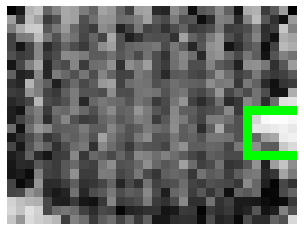

../data/video/datatest/clip000/img/image0000174.tiff


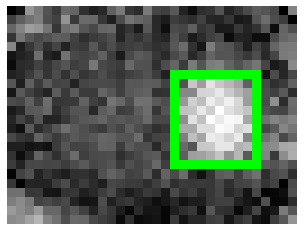

../data/video/datatest/clip000/img/image0000184.tiff


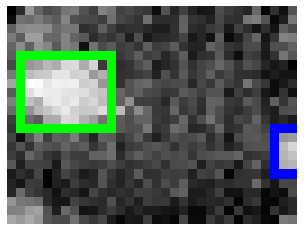

../data/video/datatest/clip000/img/image0000194.tiff


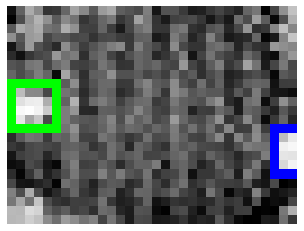

../data/video/datatest/clip000/img/image0000204.tiff


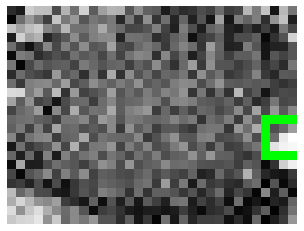

../data/video/datatest/clip000/img/image0000214.tiff


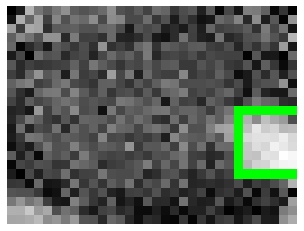

../data/video/datatest/clip000/img/image0000224.tiff


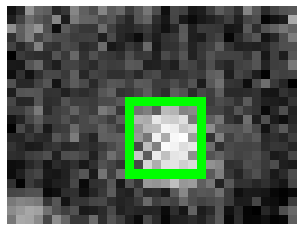

../data/video/datatest/clip000/img/image0000234.tiff


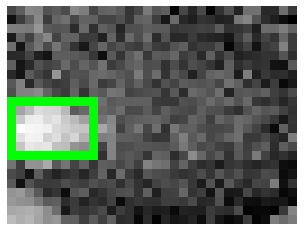

../data/video/datatest/clip000/img/image0000244.tiff


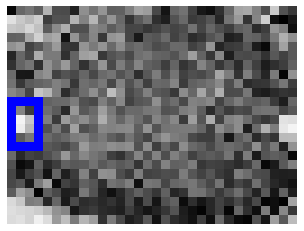

../data/video/datatest/clip000/img/image0000254.tiff


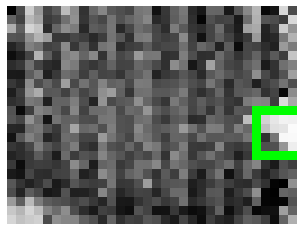

In [ ]:
def show_tf_fp_fn_ours(det, anno, threshold, show_range):
    # Filter detections based on threshold (computed in prevmatch_criteria_threshs step from F1-curve)
    filtered_det = det[det.confidence >= threshold].copy()

    # Compute TP,FP
    tpfp_det = bb.stat.match_det(filtered_det, anno, match_criteria_thresh, criteria=match_criteria)

    # Compute FN
    fn_anno = bb.stat.match_anno(det, anno, match_criteria_thresh, criteria=match_criteria)
    fn_anno = fn_anno[fn_anno.detection.isnull()]
    
    # Add correct color
    tpfp_det['color'] = [(0, 255, 0) if tp else (0, 0, 255) for tp in tpfp_det.tp]  # TP boxes green, FP boxes red
    fn_anno['color'] = [(255, 0, 0)] * fn_anno.shape[0]                             # FN boxes blue

    # Only keep necessary columns (to be able to combine dataframes)
    boxes1 = tpfp_det[['image', 'class_label', 'x_top_left', 'y_top_left', 'width', 'height', 'color']]
    boxes2 = fn_anno[['image', 'class_label', 'x_top_left', 'y_top_left', 'width', 'height', 'color']]

    # Concatenate dataframes
    boxes = bb.util.concat([boxes1, boxes2], sort=False, ignore_index=True)

    def read_image(img_id):
        img_path = os.path.join('..', 'data', 'video', 'datatest', img_id + '.tiff')
        print(img_path)
        img = cv2.imread(img_path, -1)
        img = utils.apply_agc(img)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        return img

    # Visualize
    drawer = bb.util.BoxDrawer(
        images=read_image,
        boxes=boxes,
        size=1,
        method=bb.util.DrawMethod.CV
    )

    for i in range(*show_range):
        plt.axis('off')
        plt.imshow(drawer[i])
        plt.show()
        
show_tf_fp_fn_ours(det_90_ours, anno_90, threshold_90, (164, 264, 10))
show_tf_fp_fn_ours(det_45_ours, anno_45, threshold_90, (100, 200, 10))